# Import needed libraries
To make things work ensure that you have this libraries installed.

In [2]:
# imports
import os
import numpy as np
import splitfolders
import seaborn as sns
import tensorflow as tf
from string import digits
from imutils import paths
from random import choices
from typing import Tuple, List
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.data import AUTOTUNE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import GRU, Dense, Bidirectional, InputLayer, Reshape

2024-04-07 17:41:18.194188: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 17:41:18.194304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 17:41:18.313232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data
The **Dataset** class is designed as a helper tool for loading and preparing image datasets for training machine learning models.

In [3]:
class Dataset:
    def __init__(self, path: str, output: str | None = None, ratio: Tuple[float, float, float] = (.70, .15, .15), split: bool = True, image_size: Tuple[int, int] = (224,224), batch_size: int = 8):
        self.path = path
        self.labels = [name for name in os.listdir(self.path) if os.path.isdir(os.path.join(self.path, name))]

        self.ratio = ratio
        
        self.output_path = output if output else f"./data-{''.join(choices(digits, k=5))}"
        
        self.train = os.path.sep.join([self.output_path, 'train'])
        self.val = os.path.sep.join([self.output_path, 'val'])
        self.test = os.path.sep.join([self.output_path, 'test'])
        
        self.image_size = image_size
        self.batch_size = batch_size
        
        if split:
            self.__split_folder()
        
    def __split_folder(self):
        splitfolders.ratio(self.path, output=self.output_path, seed=42, ratio=self.ratio, group_prefix=None)
    
    def generate(self) -> Tuple:
        def load_images(image_path):
            image = tf.io.read_file(image_path)
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)
            image = tf.image.resize(image, self.image_size)
            
            label = tf.strings.split(image_path, os.path.sep)[-2]
            label = tf.cast(tf.equal(self.labels, label), tf.int32)
    
            return (image, label)
        
        train_paths = list(paths.list_images(self.train))
        train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
        train_ds = (train_ds
            .shuffle(len(train_paths), reshuffle_each_iteration=True)
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(self.batch_size)
            .prefetch(AUTOTUNE)
        )
        
        val_paths = list(paths.list_images(self.val))
        val_ds = tf.data.Dataset.from_tensor_slices(val_paths)
        val_ds = (val_ds
            .shuffle(len(val_paths))
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(self.batch_size)
            .prefetch(AUTOTUNE)
        )
        
        test_paths = list(paths.list_images(self.test))
        test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
        test_ds = (test_ds
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(self.batch_size)
            .prefetch(AUTOTUNE)
        )
        
        return train_ds, val_ds, test_ds

# Helper functions
The following functions are helpful tools for visualising model training progress and evaluating model performance through confusion matrix analysis.

In [4]:
def plot_history(history, metric: str = '', ylim: List[float] | None = None):
    h = history.history
    plt.figure(figsize=(15,5))
    plt.plot(h[metric])
    plt.plot(h[f'val_{metric}'])
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend([metric, f'val_{metric}'], loc='upper left')
    if ylim:
        axes = plt.gca()
        axes.set_ylim(ylim)
    plt.show()
    
def show_confusion_matrix(y_true, y_pred, labels: List[str] = []):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(labels), len(labels)))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Bi-GRU 
The **build_model** function is a utility designed to construct and compile a model. The **STFT** and **Mel Spectrogram** are used to learn this model.

In [27]:
def build_model(height: int = 224, width: int = 224, channels: int = 3):
    input_shape = (channels, height, width) if  K.image_data_format() == 'channels_first' else (height, width, channels)
    
    # Create the model
    model = Sequential()
    model.add(InputLayer(shape=input_shape))
    model.add(Reshape((width, height * channels)))
    model.add(Bidirectional(GRU(256)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=CategoricalCrossentropy(),
        metrics=[
            CategoricalAccuracy(name='accuracy')
        ])
    
    return model

# Short-Time Fourier Transform

In [6]:
batch_size = 16
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/stft', batch_size=batch_size)
train_stft, val_stft, test_stft = dataset.generate()

Copying files: 4995 files [00:07, 670.69 files/s]


In [7]:
model = build_model()

epochs = 350

# Train the model using generator for training data and validation data
history = model.fit(train_stft,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=len(train_stft) // batch_size,
                    validation_data=val_stft,
                    validation_steps=len(val_stft) // batch_size,
                    verbose=1)

Epoch 1/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.1663 - loss: 2.2884 - val_accuracy: 0.0625 - val_loss: 2.2708
Epoch 2/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1344 - loss: 2.2776 - val_accuracy: 0.3125 - val_loss: 2.1234
Epoch 3/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2376 - loss: 2.1739 - val_accuracy: 0.2188 - val_loss: 2.1432
Epoch 4/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.2013 - loss: 2.1398 - val_accuracy: 0.2188 - val_loss: 2.0549
Epoch 5/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2619 - loss: 2.0585 - val_accuracy: 0.2812 - val_loss: 1.9875
Epoch 6/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.2313 - loss: 2.1049 - val_accuracy: 0.2812 - val_loss: 1.9827
Epoch 7/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.2901 - loss: 2.0233 - val_accuracy: 0.1875 - val_loss: 2.1924
Epoch 8/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.2535 - loss: 2.0314 - val_accuracy: 0.

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3767 - loss: 1.7878 - val_accuracy: 0.2500 - val_loss: 1.8811
Epoch 19/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3101 - loss: 1.8403 - val_accuracy: 0.4688 - val_loss: 1.5322
Epoch 20/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3268 - loss: 1.8000 - val_accuracy: 0.1875 - val_loss: 1.9577
Epoch 21/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3520 - loss: 1.6596 - val_accuracy: 0.2812 - val_loss: 1.8117
Epoch 22/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3658 - loss: 1.6643 - val_accuracy: 0.3750 - val_loss: 1.7775
Epoch 23/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3111 - loss: 1.7869 - val_accuracy: 0.3750 - val_loss: 1.7378
Epoch 24/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3542 - loss: 1.7438 - val_accuracy: 0.2308 - val_loss: 0.9265
Epoch 25/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3667 - loss: 1.7342 - val_accuracy: 0.3125 

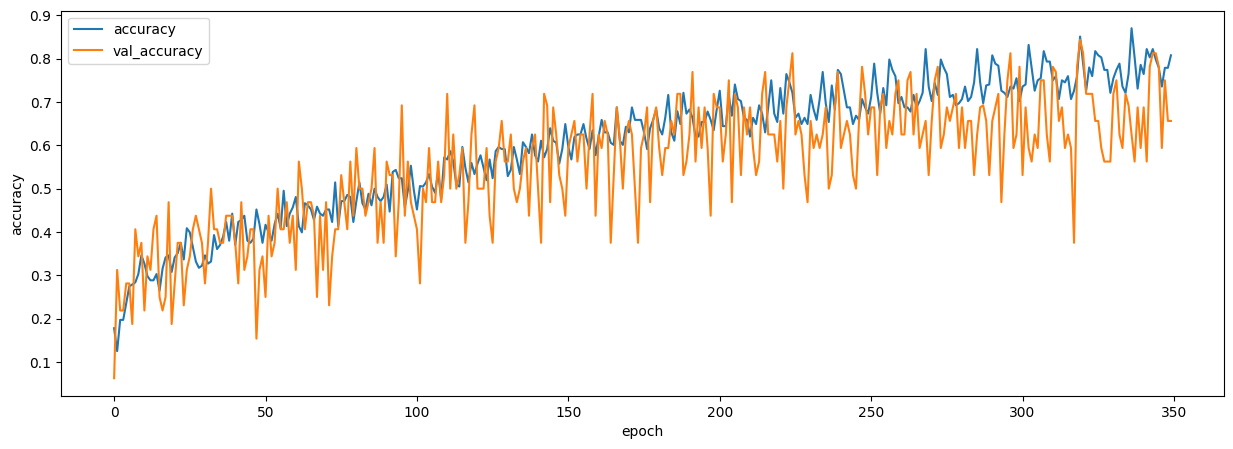

In [8]:
plot_history(history, metric='accuracy')

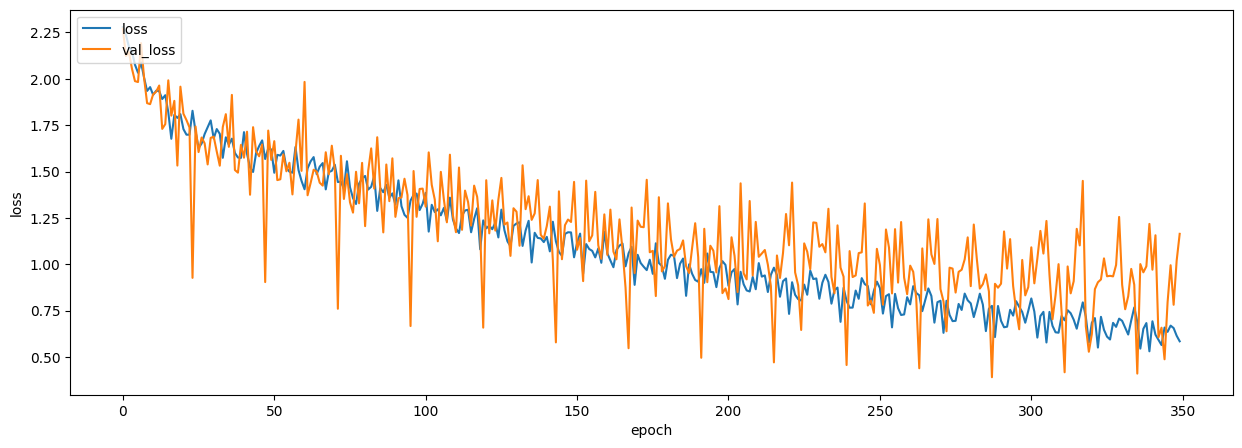

In [9]:
plot_history(history, metric='loss')

In [10]:
evaluation = model.evaluate(test_stft, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7277 - loss: 0.8374
Accuracy: 0.7200000286102295
Loss: 0.8347381949424744


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


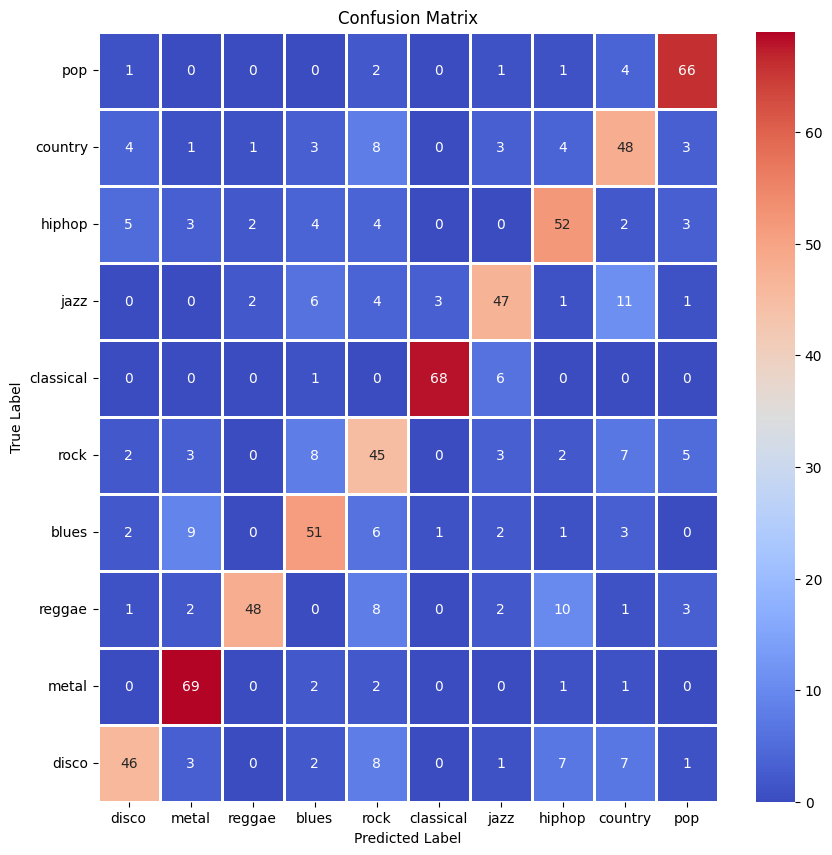

              precision    recall  f1-score   support

           0       0.75      0.61      0.68        75
           1       0.77      0.92      0.84        75
           2       0.91      0.64      0.75        75
           3       0.66      0.68      0.67        75
           4       0.52      0.60      0.56        75
           5       0.94      0.91      0.93        75
           6       0.72      0.63      0.67        75
           7       0.66      0.69      0.68        75
           8       0.57      0.64      0.60        75
           9       0.80      0.88      0.84        75

    accuracy                           0.72       750
   macro avg       0.73      0.72      0.72       750
weighted avg       0.73      0.72      0.72       750



In [11]:
y_pred = model.predict(test_stft)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in test_stft], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))

# Mel Spectogram

In [28]:
batch_size = 16
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/mel_spectrogram', batch_size=batch_size)
train_stft, val_stft, test_stft = dataset.generate()

Copying files: 4995 files [00:07, 705.55 files/s]


In [29]:
model = build_model()

epochs = 350

# Train the model using generator for training data and validation data
history = model.fit(train_stft,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=len(train_stft) // batch_size,
                    validation_data=val_stft,
                    validation_steps=len(val_stft) // batch_size,
                    verbose=1)

Epoch 1/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.1096 - loss: 2.3512 - val_accuracy: 0.2188 - val_loss: 2.3240
Epoch 2/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2564 - loss: 2.1935 - val_accuracy: 0.2188 - val_loss: 2.1607
Epoch 3/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2637 - loss: 2.1179 - val_accuracy: 0.1562 - val_loss: 2.1235
Epoch 4/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2561 - loss: 2.1022 - val_accuracy: 0.2812 - val_loss: 2.0980
Epoch 5/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2338 - loss: 2.1017 - val_accuracy: 0.3438 - val_loss: 1.9044
Epoch 6/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2734 - loss: 2.0398 - val_accuracy: 0.2188 - val_loss: 2.1432
Epoch 7/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2999 - loss: 1.9794 - val_accuracy: 0.2500 - val_loss: 2.0771
Epoch 8/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2405 - loss: 2.0491 - val_accuracy: 0.

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3100 - loss: 1.8212 - val_accuracy: 0.2812 - val_loss: 1.9616
Epoch 19/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3826 - loss: 1.7110 - val_accuracy: 0.2812 - val_loss: 1.9087
Epoch 20/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3824 - loss: 1.6768 - val_accuracy: 0.3750 - val_loss: 1.8029
Epoch 21/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3688 - loss: 1.7262 - val_accuracy: 0.4062 - val_loss: 1.5652
Epoch 22/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3248 - loss: 1.8058 - val_accuracy: 0.3750 - val_loss: 1.6151
Epoch 23/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3795 - loss: 1.7175 - val_accuracy: 0.2812 - val_loss: 1.8283
Epoch 24/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3591 - loss: 1.6903 - val_accuracy: 0.3846 - val_loss: 0.7251
Epoch 25/350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3462 - loss: 1.7575 - val_accuracy: 0.4062 

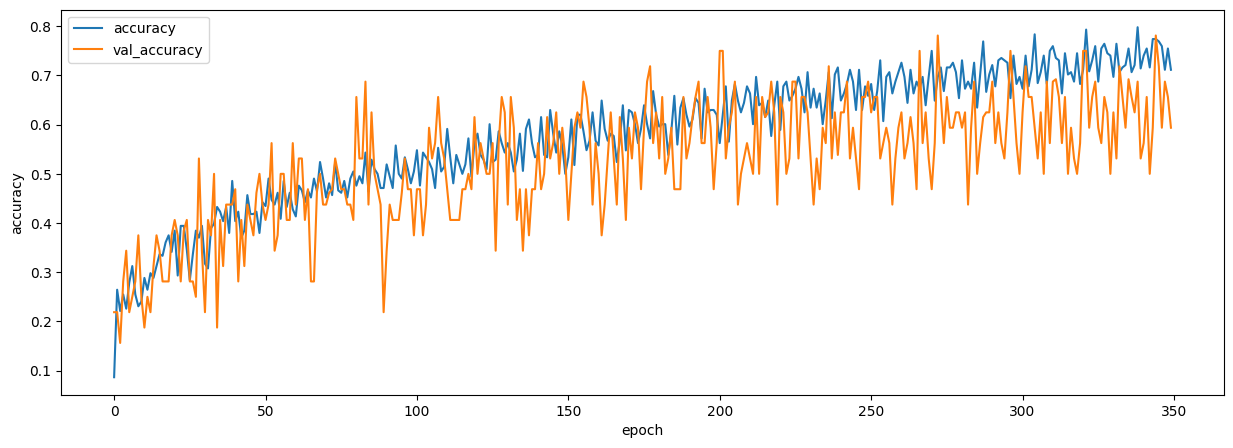

In [30]:
plot_history(history, metric='accuracy')

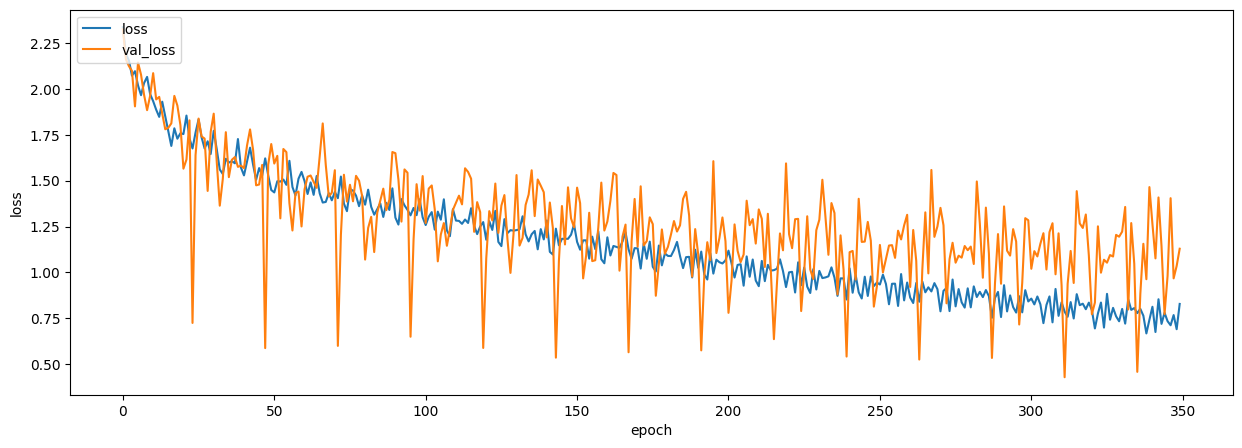

In [31]:
plot_history(history, metric='loss')

In [32]:
evaluation = model.evaluate(test_stft, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5745 - loss: 1.2495
Accuracy: 0.6079999804496765
Loss: 1.1227786540985107


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


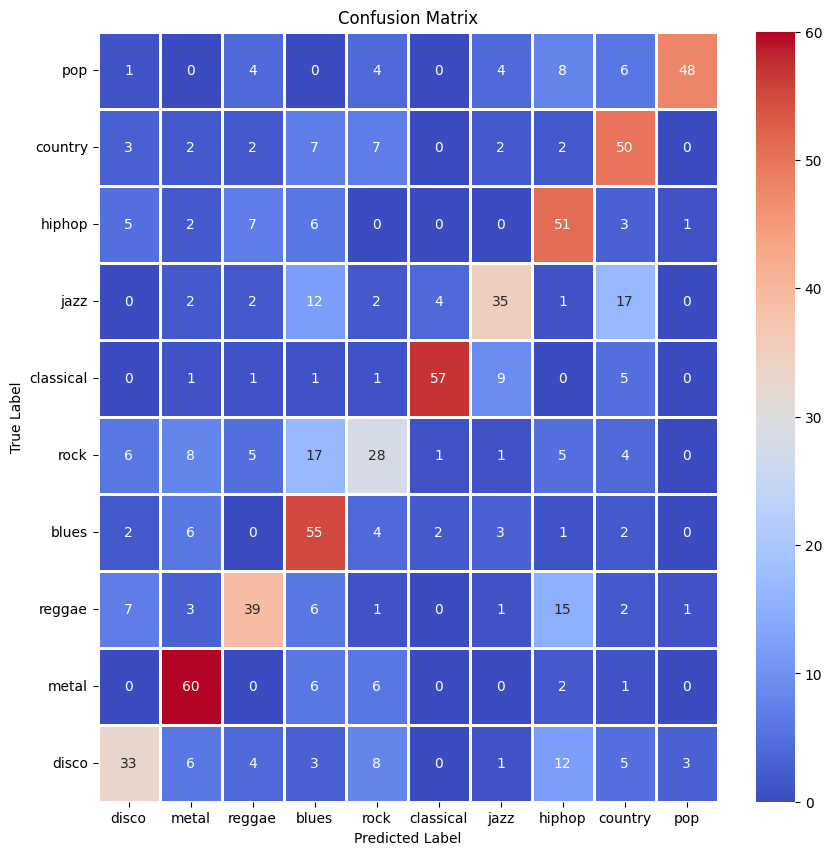

              precision    recall  f1-score   support

           0       0.58      0.44      0.50        75
           1       0.67      0.80      0.73        75
           2       0.61      0.52      0.56        75
           3       0.49      0.73      0.59        75
           4       0.46      0.37      0.41        75
           5       0.89      0.76      0.82        75
           6       0.62      0.47      0.53        75
           7       0.53      0.68      0.59        75
           8       0.53      0.67      0.59        75
           9       0.91      0.64      0.75        75

    accuracy                           0.61       750
   macro avg       0.63      0.61      0.61       750
weighted avg       0.63      0.61      0.61       750



In [33]:
y_pred = model.predict(test_stft)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in test_stft], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))